* <font color="red">assignment problem</font>. The red color indicates the task that should be done
* <font color="green">debugging</font>. The green tells you what is expected outcome. Its primarily goal is to help you get the correct answer
* <font color="blue">comments, hints</font>.

Assignment 3 (CNN)
======================


**Useful References:**
* official pytorch cifar10 tutorial


https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* tensorboard in colab


https://www.tensorflow.org/tensorboard/r2/tensorboard_in_notebooks
* tensorboard & colab


https://colab.research.google.com/drive/1NbEqqB42VSzYt-mmb4ESc8yxL05U2TIV


https://medium.com/looka-engineering/how-to-use-tensorboard-with-pytorch-in-google-colab-1f76a938bc34



## Preliminaries


#### Check the environment

In [1]:
!pwd

/content


In [2]:
!nvidia-smi

Thu Jul 18 08:22:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

#### Install missing packages

In [3]:
# [colab version] latest version of tensorflow in order to use tensorboard inside the notebook
!pip install -q tf-nightly-2.0-preview

     |████████████████████████████████| 79.7MB 3.8MB/s 
     |████████████████████████████████| 3.9MB 35.3MB/s 
     |████████████████████████████████| 450kB 43.0MB/s 
     |████████████████████████████████| 61kB 19.3MB/s 


#### Load libs, set settings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import datetime

import torch
import torchvision
import torchvision.transforms as transforms

# for tensorboard
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# random seed settings
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# for auto-reloading external modules (files, etc.)
%load_ext autoreload
%autoreload 2

# to be able to make plots inline the notebook 
# (actually no need for the colab version)
%matplotlib inline

# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

## Define pathes

In [ ]:
# path for dataset (will be not there after end of session)
path_data = "./data"

## Data

Using ``torchvision`` load CIFAR10.

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=path_data, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=path_data, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:03, 47021826.26it/s]                               


Files already downloaded and verified


In [9]:
ls data

cifar-10-batches-py/  cifar-10-python.tar.gz


Let us show some of the training images, for fun.



 ship  ship  bird horse


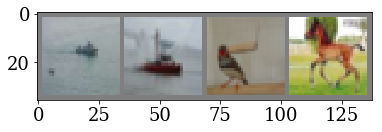

In [10]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a Convolution Neural Network

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function

Let's use a Classification Cross-Entropy loss



In [ ]:
criterion = nn.CrossEntropyLoss()

## Set-up training




In [ ]:
def train_epoch(train_loader, model, criterion, optimizer, scheduler, 
                epoch, device, log_interval, globaliter):

    # switch to train mode
    model.train()

    # adjust_learning_rate
    if scheduler is not None:
        scheduler.step()

    for batch_idx, (input_data, target) in enumerate(train_loader):
      
        # TODO: do in other way (this is global batch index, for logging)
        globaliter += 1
      
        # extract batch data
        target = target.to(device)
        input_data = input_data.to(device)

        # compute output
        output = model(input_data)
        loss = criterion(output, target)

        # compute gradient and do optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                      epoch, batch_idx * len(input_data), len(train_loader.dataset),
                      100. * batch_idx / len(train_loader), loss.item()))
        
            # log loss
            writer.add_scalar('Train/RunningLoss', loss.item(), globaliter)
            # log LR
            lr = scheduler.get_lr()[0]
            writer.add_scalar('Train/LearningRate', lr, globaliter)

    return globaliter

## Logging

In [ ]:
# path for dataset (will be not there after end of session)
current_time = str(datetime.datetime.now().timestamp())
path_log = 'logs/tensorboard/' + current_time

# set-up writer
writer = SummaryWriter(path_log)

In [ ]:
# Model (and Images) to TensorBoard (TB)

images, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)

# net to TB
writer.add_graph(net, images)

In [20]:
%tensorboard --logdir logs/tensorboard

## Training

In [ ]:
# set number of epoch
n_epochs = 5

# set-up optimizer and scheduler
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=5,
                                            gamma=0.1)

globaliter = 0
for epoch in range(1, n_epochs + 1):
    globaliter = train_epoch(trainloader, net, criterion, optimizer, scheduler, epoch, 'cpu', 500, globaliter)

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.447342
Train Epoch: 1 [2000/50000 (4%)]	Loss: 1.097813
Train Epoch: 1 [4000/50000 (8%)]	Loss: 1.278085
Train Epoch: 1 [6000/50000 (12%)]	Loss: 0.633078
Train Epoch: 1 [8000/50000 (16%)]	Loss: 1.394668
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.209085
Train Epoch: 1 [12000/50000 (24%)]	Loss: 0.226484


In [31]:
ls logs/tensorboard/

1563406670.56826/


In [ ]:
rm -r logs/tensorboard/1563406670.56826/

##  Test the network on the test data





In [24]:
# switch to test mode
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

GroundTruth:    cat  ship  ship plane


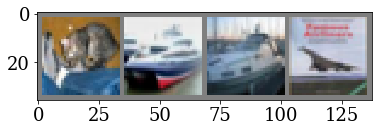

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [36]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

tensor([[-1.6661, -2.2757, -1.1531,  3.8429, -1.1546,  3.3668,  0.3805, -1.6596,
          1.0205, -2.0137],
        [ 5.0666,  8.0203, -3.1484, -2.9637, -5.0150, -6.1651, -4.7771, -4.4647,
          7.3812,  4.1658],
        [ 3.6828,  4.1640, -0.2738, -2.1851, -2.5392, -3.8587, -2.9839, -3.4138,
          4.0936,  1.7283],
        [ 4.4527,  1.1049,  0.2681, -1.2342, -0.5658, -3.1798, -2.0215, -1.9297,
          3.7219, -0.2049]], grad_fn=<AddmmBackward>)



Let us look at how the network performs on the whole dataset.



In [38]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


the classes that performed well, and the classes that did
not perform well:



In [39]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 76 %
Accuracy of  bird : 42 %
Accuracy of   cat : 43 %
Accuracy of  deer : 59 %
Accuracy of   dog : 49 %
Accuracy of  frog : 73 %
Accuracy of horse : 64 %
Accuracy of  ship : 72 %
Accuracy of truck : 63 %


## Tasks

### <font color="red"> **[PROBLEM I]**: </font>   
 <font color="red"> To get at least 65% accuracy on the validation set </font> 


#### Things to try:
- Filter size
- Number of filters
- Batch normalization
- Network architecture. Some good architectures to try include:
    - [conv-relu-pool]xN - conv - relu - [FC]xM 
    - [conv-relu-pool]XN - [FC]XM 
    - [conv-relu-conv-relu-pool]xN - [FC]xM 

#### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the course-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.

#### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. 

- Alternative update steps:  SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, or MaxOut.
- Model ensembles
- Data augmentation


#### What to expect
At the very least, you should be able to train a ConvNet that gets at least 65% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! 


